# 13. Loop-based backtesting
Advantages:
* The trading logic is straightforward to code.
* You can do way more custom stuff more easily, such as stoplosses and takeprofits. I would have no idea how to implement these in vectorized backtesting.
* It resembles live trading.

Disadvantages:
* Slow
* Possible to introduce look-ahead bias. To avoid this, you should be very careful with which data you access. If a backtest looks very good, cross-check the entry/exits.

I want to make this backtester as simple as possible. In my other repo QS_Extended, almost everything was OOP. However I find that this makes things a bit more complicated. So here I will avoid OOP unless it drastically simplifies things. For simulating a Portfolio, this makes things much easier. We will explain the Portfolio object below.

All objects and helper functions are in the 'backtester' folder.

In [18]:
from datetime import datetime, date, time
from times import get_market_dates, get_market_calendar, last_trading_date_before
from data import get_data
from tickers import get_tickers
from backtester.portfolio import Portfolio
import json
import pandas as pd

DATA_PATH = "../data/polygon/"
START_DATE = date(2019, 6, 1)
END_DATE = date(2024, 3, 1)

### 13.1 The Portfolio object and performance module

This simulates a portfolio. The portfolio has certain attributes such as the amount of cash and holdings. And several functions such as what it should do when an order gets filled. It also keeps an internal log, which we can update as often as we want (we do this every end of the day). The logs are of the portfolio itself and the fills that the portfolio got.

### 13.2 Backtesting gappers

In [ ]:
# Initialize historical scanner, portfolio and calendar
with open("../data/output/dailyscreens/GAP_30PCT.json", "r") as f:
    G30 = json.load(f)

data = {}
portfolio = Portfolio(START_DATE, data, initial_capital=10000)
calendar = get_market_calendar("datetime")
stats = []

# LOOP THROUGH ALL DAYS
for day in get_market_dates(START_DATE, END_DATE):
    # Scan for gappers
    gappers_today = G30[day.isoformat()]
    if not gappers_today:
        continue

    # AT MARKET OPEN, calculate gaps and enter positions
    # Get data
    """
    The reason we don't use data = {}: We want the data and portfolio.data to refer to the same
    dictionary. When we use data = {}, this creates a NEW dictionary. Thus data will refer to
    this new dictionary and not the old. Then portfolio.data refers to the old. 
    When we do data.clear(), it empties the dictionary but does not create a new one.
    """
    data.clear() 
    previous_close_dt = calendar.loc[last_trading_date_before(day), "regular_close"]
    market_open_dt = calendar.loc[day, "regular_open"]
    market_close_dt = calendar.loc[day, "regular_close"]
    for gapper in gappers_today:
        data[gapper] = get_data(
            gapper,
            previous_close_dt,
            market_close_dt,
            1,
            columns=["open", "high", "close", "tradeable", "close_original"],
        )

    # Calculate gaps
    gap = {}
    for gapper in gappers_today:
        previous_close = data[gapper].loc[previous_close_dt, "close"]
        current_open = data[gapper].loc[market_open_dt, "open"]
        gap[gapper] = current_open / previous_close

    # Get the top gappers
    sorted_gap = sorted(gap.items(), key=lambda x: x[1], reverse=True)

    # Market order with 20% of cash
    size = portfolio.current_cash * 0.2
    for trade_no, gapper in enumerate(gappers_today):
        current_open = data[gapper].loc[market_open_dt, "open"]
        quantity = int(size / current_open)
        portfolio.update_from_fill(
            dt=market_open_dt,
            side="SELL",
            symbol=gapper,
            fill_quantity=quantity,
            fill_price=current_open,
            fees=current_open*0.01*abs(quantity),
        )
        if trade_no + 1 == 5:
            break

    # TODO: Implement stoploss

    # AT MARKET CLOSE: close all positions, update portfolio
    for symbol, quantity in portfolio.current_positions.items():
        if quantity != 0:
            close_price = data[symbol].loc[market_close_dt, "close"]
            action = "SELL" if quantity > 0 else "BUY"
            portfolio.update_from_fill(
                dt=market_close_dt,
                side=action,
                symbol=symbol,
                fill_quantity=abs(quantity),
                fill_price=close_price,
                fees=close_price*0.01*abs(quantity),
            )
    
    # LOG STATISTICS: SPIKEET STYLE
    for gapper in gappers_today:
        stats.append({'day': day,
                    'ticker': gapper,
                    'prev_close': data[gapper].loc[previous_close_dt, "close"],
                    'open': data[gapper].loc[market_open_dt, "open"],
                    'open_original': data[gapper].loc[market_open_dt, "close_original"], # not exactly correct
                    'high': data[gapper].loc[market_open_dt:market_close_dt, 'high'].max(),
                    'close': data[gapper].loc[market_close_dt, "close"],
                    })
               
    portfolio.append_portfolio_log(market_close_dt)
    print(day)

# END OF BACKTEST
stats = pd.DataFrame(stats)
stats.set_index("day", inplace=True)
stats.to_excel("../data/output/gappers.xlsx")

In [23]:
from backtester.performance import fills_to_trades
portfolio_log = portfolio.get_df_from_holdings_log()
fills_log = portfolio.get_df_from_fills_log()
trade_log = fills_to_trades(fills_log) # Need to make this faster
trade_log = trade_log.drop(columns=['remaining_qty', 'net P/L $', 'fees'])

In [ ]:
fills_log.tail(3)

,symbol,side,quantity,fill_price,fees
datetime,,,,,
2024-03-01 15:59:00,DELL-2019-06-03,BUY,10190,124.54,12690.6260
2024-03-01 15:59:00,MINM-2021-07-07,BUY,218293,5.82,12704.6526
2024-03-01 15:59:00,MTC-2019-06-03,BUY,747335,2.55,19057.0425


In [ ]:
len(trade_log)

2931

In [ ]:
trade_log[trade_log['net P/L %'] < -100].sort_values(by=['net P/L %']).head()

,datetime_in,symbol,side,quantity,entry,exit,datetime_out,net P/L %
2859,2024-02-07 09:30:00,HOLO-2022-09-19,SELL,864156,3.76,18.64,2024-02-07 15:59:00,-401.70
2663,2023-10-11 09:30:00,TPST-2021-06-28,SELL,3909685,2.13,9.27,2023-10-11 15:59:00,-340.56
2130,2022-12-09 09:30:00,AMAM-2021-06-17,SELL,8691423,1.17,4.54,2022-12-09 15:59:00,-292.91
774,2020-09-23 09:30:00,SPI-2019-06-03,SELL,140401,3.54,13.61,2020-09-23 15:59:00,-289.31
1122,2021-02-04 09:30:00,AACG-2019-10-17,SELL,243628,3.67,14.00,2021-02-04 15:59:00,-286.29


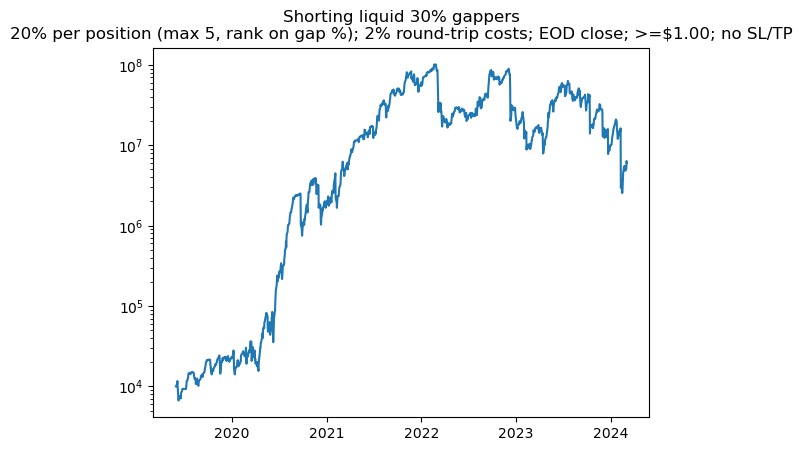

In [ ]:
from matplotlib import pyplot as plt
plt.plot(portfolio_log.index, portfolio_log.equity)
plt.yscale("log")
plt.title('Shorting liquid 30% gappers\n20% per position (max 5, rank on gap %); 2% round-trip costs; EOD close; >=$1.00; no SL/TP')
plt.show()

I am going to show the flexibility and will backtest the following systems:
* Pre-market gap short with 10% stoploss and hold to EOD
* IBS strategy on SPY, with realistic entries (that is, not exactly at market close but 1 minute before)
* Every week, buy the 5 stocks in the T500 that have the largest distance to the moving average